In [229]:
#!pip install catboost

In [234]:
#importing dependencies
import pandas as pd
import numpy as np

import seaborn as sns 

from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.preprocessing import OneHotEncoder , FunctionTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyRegressor, DummyClassifier
from sklearn.metrics import plot_confusion_matrix, recall_score,\
    accuracy_score, precision_score, f1_score
from sklearn.inspection import permutation_importance
from catboost import CatBoostClassifier

In [165]:
df = pd.read_csv(r"C:\Users\Owner\Desktop\Python\Side Projects\Credit Risk\Data\credit_risk_dataset.csv")

# EDA

In [166]:
df

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4
...,...,...,...,...,...,...,...,...,...,...,...,...
32576,57,53000,MORTGAGE,1.0,PERSONAL,C,5800,13.16,0,0.11,N,30
32577,54,120000,MORTGAGE,4.0,PERSONAL,A,17625,7.49,0,0.15,N,19
32578,65,76000,RENT,3.0,HOMEIMPROVEMENT,B,35000,10.99,1,0.46,N,28
32579,56,150000,MORTGAGE,5.0,PERSONAL,B,15000,11.48,0,0.10,N,26


In [167]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


In [168]:
#Checking for missing values
df.isna().sum()

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              895
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3116
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64

Missing data for loan_int_rate and person_emp_length, 4 categorical variables

In [169]:
df.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
count,32581.000000,3.258100e+04,31686.000000,32581.000000,29465.000000,32581.000000,32581.000000,32581.000000
mean,27.734600,6.607485e+04,4.789686,9589.371106,11.011695,0.218164,0.170203,5.804211
std,6.348078,6.198312e+04,4.142630,6322.086646,3.240459,0.413006,0.106782,4.055001
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,0.000000,2.000000
25%,23.000000,3.850000e+04,2.000000,5000.000000,7.900000,0.000000,0.090000,3.000000
50%,26.000000,5.500000e+04,4.000000,8000.000000,10.990000,0.000000,0.150000,4.000000
75%,30.000000,7.920000e+04,7.000000,12200.000000,13.470000,0.000000,0.230000,8.000000
max,144.000000,6.000000e+06,123.000000,35000.000000,23.220000,1.000000,0.830000,30.000000


In [170]:
df.describe(include="object").T

,count,unique,top,freq
person_home_ownership,32581,4,RENT,16446
loan_intent,32581,6,EDUCATION,6453
loan_grade,32581,7,A,10777
cb_person_default_on_file,32581,2,N,26836


Max age showing 144 years old, will need to investigate.  Similar issue with employment length


### Investigating max age and employment length

In [171]:
#Choosing 80+ as age, arbitrarily
df[df["person_age"]>80]

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
81,144,250000,RENT,4.0,VENTURE,C,4800,13.57,0,0.02,N,3
183,144,200000,MORTGAGE,4.0,EDUCATION,B,6000,11.86,0,0.03,N,2
575,123,80004,RENT,2.0,EDUCATION,B,20400,10.25,0,0.25,N,3
747,123,78000,RENT,7.0,VENTURE,B,20000,NaN,0,0.26,N,4
32297,144,6000000,MORTGAGE,12.0,PERSONAL,C,5000,12.73,0,0.00,N,25
32416,94,24000,RENT,1.0,MEDICAL,C,6500,NaN,0,0.27,N,27
32506,84,94800,MORTGAGE,2.0,PERSONAL,A,10000,7.51,0,0.11,N,24


In [172]:
df[df["person_age"]>80].iloc[0:4]

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
81,144,250000,RENT,4.0,VENTURE,C,4800,13.57,0,0.02,N,3
183,144,200000,MORTGAGE,4.0,EDUCATION,B,6000,11.86,0,0.03,N,2
575,123,80004,RENT,2.0,EDUCATION,B,20400,10.25,0,0.25,N,3
747,123,78000,RENT,7.0,VENTURE,B,20000,NaN,0,0.26,N,4


The data for the persons above the age of 100 may be a typo as 4 of the entities have 2-7 years of employement, 3-4 years of credit history and some of the loans are to be used for education.

In [173]:
df[df["person_age"]>80].iloc[4:5]

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
32297,144,6000000,MORTGAGE,12.0,PERSONAL,C,5000,12.73,0,0.0,N,25


This may also be a typo because if the persons age is 44 and they have 25 years of credit, that would mean their credit started at 19 years old.

Without having access to the other data for these individuals in order to validate and update the information, I will be dropping these 4 individuals from the dataset.

In [174]:
df[df["person_emp_length"]>50]

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
210,21,192000,MORTGAGE,123.0,VENTURE,A,20000,6.54,0,0.10,N,4


The employment length is a typo, will replace values with mean(4 years).

In [175]:
df["person_emp_length"] = np.where(df["person_emp_length"] >50, df["person_emp_length"].mean() ,df['person_emp_length'])

In [176]:
#Updating df to remove the 4 individuals with the age typos

df = df[df["person_age"]< 100]

In [177]:
#Checking data to make sure updates were made
df.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
count,32576.000000,3.257600e+04,31681.000000,32576.000000,29461.000000,32576.000000,32576.000000,32576.000000
mean,27.718044,6.588214e+04,4.782064,9589.117755,11.011547,0.218197,0.170212,5.803966
std,6.204990,5.253499e+04,4.034821,6321.886846,3.240623,0.413029,0.106778,4.053791
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,0.000000,2.000000
25%,23.000000,3.850000e+04,2.000000,5000.000000,7.900000,0.000000,0.090000,3.000000
50%,26.000000,5.500000e+04,4.000000,8000.000000,10.990000,0.000000,0.150000,4.000000
75%,30.000000,7.920000e+04,7.000000,12200.000000,13.470000,0.000000,0.230000,8.000000
max,94.000000,2.039784e+06,41.000000,35000.000000,23.220000,1.000000,0.830000,30.000000


In [178]:
#Target variable
from locale import normalize

loan_status_counts = df.loan_status.value_counts(normalize=True)
loan_status_counts

0    0.781803
1    0.218197
Name: loan_status, dtype: float64

In [179]:

def countplot(col):
    sns.countplot(df[col])
    plt.title(col,fontsize=15)
    plt.show()

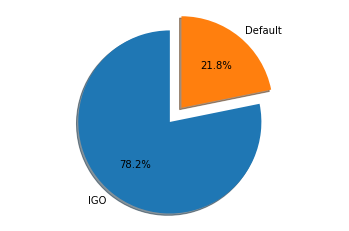

In [180]:
labels = ["IGO","Default"]
sizes = [loan_status_counts[0], loan_status_counts[1]]
explode = (0, 0.2)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

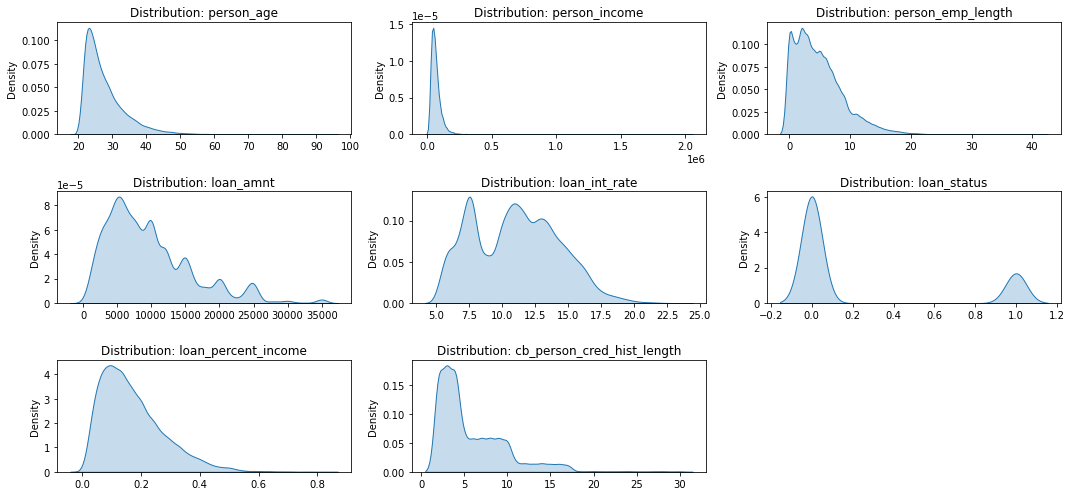

In [181]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 7), sharex = False, sharey = False)
axes = axes.ravel()  
cols = df.select_dtypes(include="number").columns[:]

for col, ax in zip(cols, axes):
    data = df.select_dtypes(include="number")
    sns.kdeplot(data=data, x=col, shade=True, ax=ax)
    ax.set(title=f'Distribution: {col}', xlabel=None)
    
fig.delaxes(axes[8])
fig.tight_layout()
plt.show()

# Modeling

#### Splitting data into training and test set to avoid data leakage when handling missing values

In [185]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32576 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32576 non-null  int64  
 1   person_income               32576 non-null  int64  
 2   person_home_ownership       32576 non-null  object 
 3   person_emp_length           31681 non-null  float64
 4   loan_intent                 32576 non-null  object 
 5   loan_grade                  32576 non-null  object 
 6   loan_amnt                   32576 non-null  int64  
 7   loan_int_rate               29461 non-null  float64
 8   loan_status                 32576 non-null  int64  
 9   loan_percent_income         32576 non-null  float64
 10  cb_person_default_on_file   32576 non-null  object 
 11  cb_person_cred_hist_length  32576 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 4.2+ MB


In [182]:
X = df.drop(["loan_status"], axis=1)
y = df['loan_status']

In [184]:
#Splitting the data to test train split with random state for reproduction
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=112)

In [190]:
#Function to select dtype int64 from df
def grab_numeric(df):
    return df.select_dtypes(include=['int64', "float64"])

In [202]:
def grab_categorical(df):
    return df.select_dtypes(include=['object'])

In [201]:
grab_numeric(df)

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
0,22,59000,4.789686,35000,16.02,1,0.59,3
1,21,9600,5.000000,1000,11.14,0,0.10,2
2,25,9600,1.000000,5500,12.87,1,0.57,3
3,23,65500,4.000000,35000,15.23,1,0.53,2
4,24,54400,8.000000,35000,14.27,1,0.55,4
...,...,...,...,...,...,...,...,...
32576,57,53000,1.000000,5800,13.16,0,0.11,30
32577,54,120000,4.000000,17625,7.49,0,0.15,19
32578,65,76000,3.000000,35000,10.99,1,0.46,28
32579,56,150000,5.000000,15000,11.48,0,0.10,26


In [203]:
grab_categorical(df)

,person_home_ownership,loan_intent,loan_grade,cb_person_default_on_file
0,RENT,PERSONAL,D,Y
1,OWN,EDUCATION,B,N
2,MORTGAGE,MEDICAL,C,N
3,RENT,MEDICAL,C,N
4,RENT,MEDICAL,C,Y
...,...,...,...,...
32576,MORTGAGE,PERSONAL,C,N
32577,MORTGAGE,PERSONAL,A,N
32578,RENT,HOMEIMPROVEMENT,B,N
32579,MORTGAGE,PERSONAL,B,N


In [192]:
#Calling function
GrabNumeric = FunctionTransformer(grab_numeric)

In [195]:
#Creating pipeline 
pipe= Pipeline(steps=[("num", GrabNumeric),#Step 1 will pull the numerical values
                      ( "ss", StandardScaler())])#Step 2 will use standard scaler

In [196]:
#Fitting X_train to pipe
pipe.fit(X_train)

Pipeline(steps=[('num',
                 FunctionTransformer(func=<function grab_numeric at 0x0000019766D66EE0>)),
                ('ss', StandardScaler())])

In [197]:
#Transforming X_train
pipe.transform(X_train)

array([[ 0.04416058, -0.57245856, -0.43933942, ..., -1.08344338,
        -0.56243633,  0.04776361],
       [ 0.04416058,  0.38277017, -1.18151536, ...,  0.94776592,
         0.1839047 ,  0.04776361],
       [-0.75789963, -0.50852593, -0.6867314 , ...,  1.28937839,
         0.8369531 , -0.69159888],
       ...,
       [-0.59748759,  2.23666605,  0.5502285 , ...,  1.06163674,
        -0.4691437 , -0.44514472],
       [-0.91831168, -0.30168507, -1.18151536, ..., -0.96341737,
         0.27719733, -0.69159888],
       [-0.59748759,  0.07431402, -0.43933942, ...,  0.4676619 ,
        -1.21548474, -0.44514472]])

In [206]:
j = -1
for i in X_train.columns:
    j+=1
    print("Index Number", j,i)

Index Number 0 person_age
Index Number 1 person_income
Index Number 2 person_home_ownership
Index Number 3 person_emp_length
Index Number 4 loan_intent
Index Number 5 loan_grade
Index Number 6 loan_amnt
Index Number 7 loan_int_rate
Index Number 8 loan_percent_income
Index Number 9 cb_person_default_on_file
Index Number 10 cb_person_cred_hist_length


In [199]:
subpipe_num = Pipeline(steps=[('num_impute', SimpleImputer(strategy="median")),#Replace missing values with median
                           ('ss', StandardScaler())])#use standard scaler for numerical values
subpipe_cat = Pipeline(steps=[('cat_impute', SimpleImputer(strategy='constant')),#Replace missing values with fill_value
                             ('OHE', OneHotEncoder(sparse=False, handle_unknown='ignore'))])#Use onehotencoder for categorical data

In [210]:
#Transforming columns that are numerical and categorical
CT = ColumnTransformer(transformers=[('subpipe_num', subpipe_num, [0,1,3,6,7,8,10]),#Choosing index location 1(gps_height) and 7(population) 
                                         ('subpipe_cat', subpipe_cat, [2,4,5,9])])#Choosing remaining index locations

# Dummy Classifier

In [212]:
dummy_model_pipe = Pipeline(steps=([("ct", CT), 
                                    ("dc", DummyClassifier())]))
dummy_model_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  [0, 1, 3, 6, 7, 8, 10]),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='constant')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                               

In [225]:
print(f"""
    Training Accuracy Score: {round(accuracy_score(y_train, dummy_model_pipe.predict(X_train)),4)} 
    Testing Accuracy Score: {round(accuracy_score(y_test, dummy_model_pipe.predict(X_test)),4)}
    
    Training Precision Score: {round(precision_score(y_train, dummy_model_pipe.predict(X_train), average= 'weighted'),4)}
    Testing Precision Score: {round(precision_score(y_test, dummy_model_pipe.predict(X_test), average= 'weighted'),4)} 
    
    Training Recall Score: {round(recall_score(y_train, dummy_model_pipe.predict(X_train), average= 'weighted'),4)}
    Testing Recall Score: {round(recall_score(y_test, dummy_model_pipe.predict(X_test), average= 'weighted'),4)} 
    
    Training F1 Score: {round(f1_score(y_train, dummy_model_pipe.predict(X_train), average= 'weighted'),4)}
    Testing F1 Score: {round(f1_score(y_test, dummy_model_pipe.predict(X_test), average= 'weighted'),4)} 
    
    Confusion Matrix:""")
              
                                 


    Training Accuracy Score: 0.7841 
    Testing Accuracy Score: 0.7748
    
    Training Precision Score: 0.6149
    Testing Precision Score: 0.6003 
    
    Training Recall Score: 0.7841
    Testing Recall Score: 0.7748 
    
    Training F1 Score: 0.6893
    Testing F1 Score: 0.6765 
    
    Confusion Matrix:


c:\Users\Owner\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Owner\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [231]:
cat_boost_pipe = Pipeline([('ct', CT), ('cat', CatBoostClassifier(iterations=10000, od_type = "Iter", od_wait=1000, ))])
cat_boost_pipe.fit(X_train, y_train)

Learning rate set to 0.004882
0:	learn: 0.6878185	total: 156ms	remaining: 26m 1s
1:	learn: 0.6824380	total: 163ms	remaining: 13m 35s
2:	learn: 0.6773684	total: 169ms	remaining: 9m 23s
3:	learn: 0.6721943	total: 176ms	remaining: 7m 19s
4:	learn: 0.6670376	total: 182ms	remaining: 6m 3s
5:	learn: 0.6619001	total: 189ms	remaining: 5m 14s
6:	learn: 0.6575594	total: 195ms	remaining: 4m 38s
7:	learn: 0.6530477	total: 202ms	remaining: 4m 12s
8:	learn: 0.6481646	total: 209ms	remaining: 3m 51s
9:	learn: 0.6436529	total: 215ms	remaining: 3m 34s
10:	learn: 0.6394743	total: 222ms	remaining: 3m 21s
11:	learn: 0.6354931	total: 229ms	remaining: 3m 10s
12:	learn: 0.6309456	total: 235ms	remaining: 3m
13:	learn: 0.6261729	total: 243ms	remaining: 2m 53s
14:	learn: 0.6222423	total: 249ms	remaining: 2m 46s
15:	learn: 0.6180871	total: 256ms	remaining: 2m 39s
16:	learn: 0.6139784	total: 263ms	remaining: 2m 34s
17:	learn: 0.6103866	total: 269ms	remaining: 2m 29s
18:	learn: 0.6059743	total: 276ms	remaining: 2m 

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  [0, 1, 3, 6, 7, 8, 10]),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='constant')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                               

In [237]:
print(f"""
    Training Accuracy Score: {round(accuracy_score(y_train, cat_boost_pipe.predict(X_train)),4)} 
    Testing Accuracy Score: {round(accuracy_score(y_test, cat_boost_pipe.predict(X_test)),4)}
    
    Training Precision Score: {round(precision_score(y_train, cat_boost_pipe.predict(X_train), average= 'weighted'),4)}
    Testing Precision Score: {round(precision_score(y_test, cat_boost_pipe.predict(X_test), average= 'weighted'),4)} 
    
    Training Recall Score: {round(recall_score(y_train, cat_boost_pipe.predict(X_train), average= 'weighted'),4)}
    Testing Recall Score: {round(recall_score(y_test, cat_boost_pipe.predict(X_test), average= 'weighted'),4)} 
    
    Training F1 Score: {round(f1_score(y_train, cat_boost_pipe.predict(X_train), average= 'weighted'),4)}
    Testing F1 Score: {round(f1_score(y_test, cat_boost_pipe.predict(X_test), average= 'weighted'),4)} 
    
    Confusion Matrix:""")


    Training Accuracy Score: 0.9532 
    Testing Accuracy Score: 0.9354
    
    Training Precision Score: 0.9553
    Testing Precision Score: 0.9387 
    
    Training Recall Score: 0.9532
    Testing Recall Score: 0.9354 
    
    Training F1 Score: 0.9512
    Testing F1 Score: 0.9318 
    
    Confusion Matrix:


Accuracy and precision score increased to 93% on test data

In [235]:
result = permutation_importance(cat_boost_pipe, X_test, y_test)

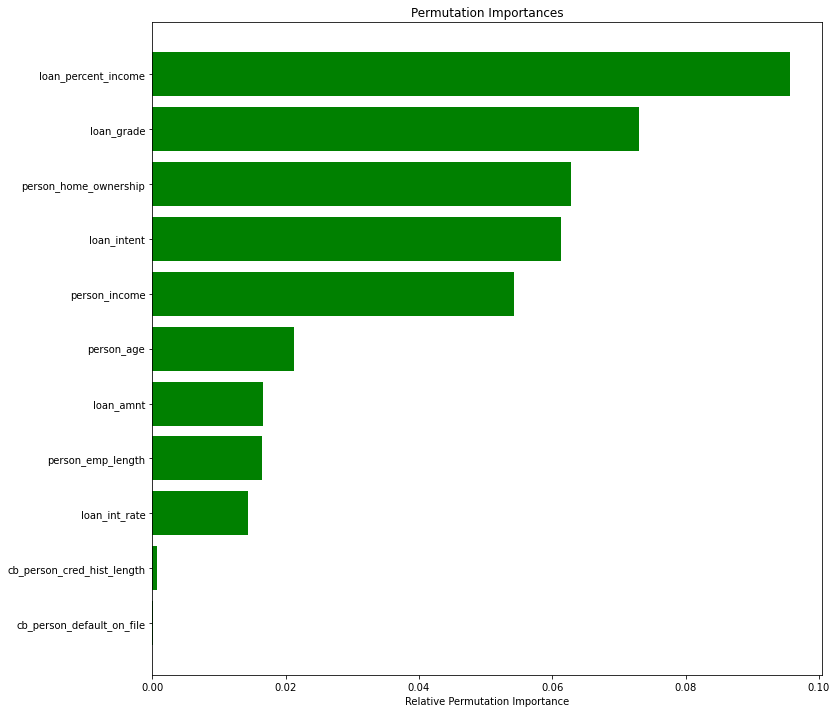

In [236]:
Permutation_names = list(X.columns)
Permutations = abs(result.importances_mean)
indices = np.argsort(Permutations)
plt.figure(figsize=(12,12))
plt.title('Permutation Importances')
plt.barh(range(len(indices)), Permutations[indices], color= 'g')
plt.yticks(range(len(indices)), [Permutation_names[i] for i in indices])
plt.xlabel('Relative Permutation Importance')
plt.savefig('perm.png')
plt.show()

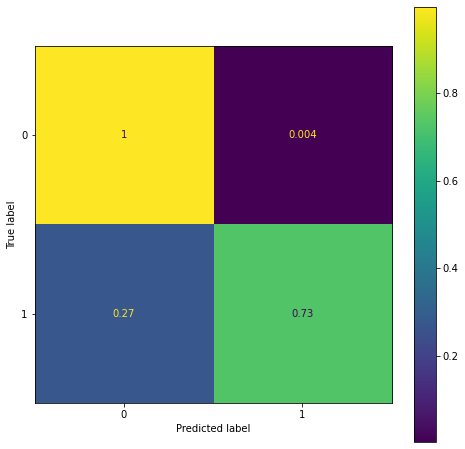

In [240]:
fig, ax = plt.subplots(figsize=(8, 8))
plot_confusion_matrix(cat_boost_pipe, X_test, y_test, normalize = 'true', ax=ax)                        
                                 